In [15]:
import jax
from jax import numpy as jnp
from typing import Union
import pickle
import copy
from bsc_utils.miscellaneous import multimodal_normal_sampling
from bsc_utils.controller.base import ExplicitMLP
from bsc_utils.simulate.analyze import Simulator
from bsc_utils.miscellaneous import load_config_from_yaml
from bsc_utils.miscellaneous import complete_config_with_defaults
import time
import numpy as np

from mediapy import show_video

from bsc_utils.visualization import post_render

rng = jax.random.PRNGKey(0)

In [2]:
### Configurables
simulation_time = 0.6

# consolidation network
num_hidden = 2
nodes_hidden = 4

# Kernel initialisation
means = [-3,3]
stds = [1,1]
trunc_mins = [-6,0]
trunc_maxs = [0,6]

# means = [0]
# stds = [0.5]
# trunc_mins = [-1]
# trunc_maxs = [1]


alpha = 0.1

In [3]:
with open("observations.pkl", "rb") as file:
    observations_all = pickle.load(file)
observations = jnp.concatenate(
    [observations_all[label] for label in ('joint_position', 'joint_actuator_force', 'segment_contact')],
    axis = 1
)
observations = observations[0].T

with open("nn_params_example.pkl", "rb") as file:
    nn_params_example = pickle.load(file)

actions = jnp.load("actions.npy")[0].T
rewards = jnp.load("rewards.npy")[0]

print(actions.shape)
print(rewards.shape)
print(observations.shape)
print(jax.tree.map(lambda x: x.shape, nn_params_example))

(250, 50)
(250,)
(250, 125)
{'params': {'layers_0': {'bias': (128,), 'kernel': (125, 128)}, 'layers_1': {'bias': (128,), 'kernel': (128, 128)}, 'layers_2': {'bias': (50,), 'kernel': (128, 50)}}}


In [4]:
# make explictMLP with way more layers and biases
# generate fictional rollout, at the end of every rollout, you manually set the output as desired

In [5]:
hidden_layers = []

for i in range(num_hidden):
    hidden_layers += [nodes_hidden]

input_dim = nn_params_example["params"]["layers_0"]["kernel"].shape[0]
output_dim = nn_params_example["params"]["layers_2"]["kernel"].shape[1]

layers = [input_dim] + hidden_layers + [output_dim]
print(layers)

[125, 4, 4, 50]


In [6]:
cons_contr = ExplicitMLP(features = layers[1:], joint_control = "position")

rng, rng_init = jax.random.split(rng, 2)
cons_contr_params = cons_contr.init(rng_init, jnp.zeros(layers[0]))

print(jax.tree.map(lambda x: x.size, cons_contr_params))

{'params': {'layers_0': {'bias': 4, 'kernel': 500}, 'layers_1': {'bias': 4, 'kernel': 16}, 'layers_2': {'bias': 50, 'kernel': 200}}}


In [7]:
def identical(x):
    return x

In [8]:
def DNN_rollout(params_dict, input, act_hidden=jnp.tanh, act_output=jnp.tanh, joint_control="position"):
    num_layers = len(params_dict["params"].keys())
    neuron_activities = [input]
    for p in range(num_layers):
        kernel = params_dict["params"][f"layers_{p}"]["kernel"]
        bias = params_dict["params"][f"layers_{p}"]["bias"]
        output = jnp.dot(input,kernel)
        output = output+bias

        ### !!! activity which is stored is not yet rescaled by the tanh function
        neuron_activities.append(output)
        if p != num_layers-1:
            output = act_hidden(output)
        elif p == num_layers-1:
            assert joint_control in ['position', 'torque'], "joint_control should be either 'position' or 'torque'"
            if joint_control == 'position':
                output = 30*jnp.pi/180 * act_output(output) # the action space range for positions is -0.5236..0.5236
            elif joint_control == 'torque':
                output = act_output(output) # the action space range for torques is -1..1
        
        input = output
    return output, neuron_activities

In [9]:
def initialise_cons_contr_params(path, leaf):
    rng = jax.random.PRNGKey(2000)
    rng, rng_init = jax.random.split(rng, 2)
    if "kernel" in jax.tree_util.keystr(path):
        leaf_old = leaf
        sample_sizes = [int(leaf_old.size/len(means)) for _ in range(len(means))]
        values = multimodal_normal_sampling(rng,
                                            means,
                                            stds,
                                            sample_sizes,
                                            trunc_mins,
                                            trunc_maxs)
        leaf = jnp.reshape(values, leaf_old.shape)
        return leaf  # Modify leaf
    elif "bias" in jax.tree_util.keystr(path):
        leaf = leaf*0
        return leaf  # Modify leaf
    return leaf  # Keep unchanged otherwise

cons_contr_params = jax.tree_util.tree_map_with_path(initialise_cons_contr_params, cons_contr_params)
# print(cons_contr_params)


In [16]:
def synaptic_competition(input_nodes,
                         output_nodes,
                         synapse_strengths,
                         learning_rate = 0.1
                         ):
    synapse_strengths = np.array(synapse_strengths)
    for i in range(len(output_nodes)):
        for j in range(len(input_nodes)):
            synapse_strengths[j,i] = synapse_strengths[j,i] + learning_rate * input_nodes[j] * output_nodes[i]
        if max(synapse_strengths[:,i]) > 1:
            synapse_strengths[:,i]/max(synapse_strengths[:,i])

    return jnp.array(synapse_strengths)

def apply_oja(input_nodes,
            output_nodes,
            synapse_strengths,
            alpha = 0.1
            ):
    
    """ 
    Input: 
    - learning rule kernel: dims (popsize, input_layer_dim, output_layer_dim, lr_dim = 5)
    - learning_rule: only "ABCD" implemented so far.
    Output: synaptic strength increment kernel: dims (popsize, input_layer_dim, output_layer_dim)
    This function is vmapable and jittable
    """
    in_dim = len(input_nodes)
    out_dim = len(output_nodes)
    inp = jnp.transpose(jnp.tile(input_nodes, (out_dim, 1))) # Generates (in_dim, out_dim) dimension, but constant along axis = 1 (output dimension)
    outp = jnp.tile(output_nodes, (in_dim, 1)) # Generates (in_dim, out_dim) dimension, but constant along axis = 0 (input dimesnion)
    # these dimensions are required for matrix multiplications

    # kernel content: [alpha, A, B, C, D] --> Dw_ij = alpha_ij * (A_ij*o_i*o_j + B_ij * o_i + C_ij * o_j + D_ij)



    ss_incr = alpha * (inp*outp - synapse_strengths * outp**2) # 10*synapse_strengths*outp)
    return ss_incr

    ss_factor = jnp.exp(ss_incr)
    return ss_factor # synaptic strength multiplication factor


def update_synapse_strengths(
        synapse_strengths_input,
        neuron_activities,
        alpha = 0.1
):
    synapse_strengths = copy.deepcopy(synapse_strengths_input)

    num_layers = len(synapse_strengths["params"].keys())
    for p in range(num_layers):
        input_nodes = neuron_activities[p]
        output_nodes = neuron_activities[p+1]
        ss = synapse_strengths["params"][f"layers_{p}"]["kernel"]
        # ss_factor = apply_oja(input_nodes, output_nodes, ss, alpha = alpha)
        # synapse_strengths["params"][f"layers_{p}"]["kernel"] = synapse_strengths["params"][f"layers_{p}"]["kernel"] * ss_factor
        # synapse_strengths["params"][f"layers_{p}"]["kernel"] = synapse_strengths["params"][f"layers_{p}"]["kernel"] + ss_factor
        synapse_strengths["params"][f"layers_{p}"]["kernel"] = synaptic_competition(input_nodes, output_nodes, synapse_strengths=ss)

    return synapse_strengths


In [17]:

from flax import linen as nn

for i in range(observations.shape[0]):
    # print("observations: ", observations[i,:5])
    # _, neuron_activities = DNN_rollout(cons_contr_params, observations[i,:], act_hidden = nn.tanh, act_output=nn.tanh)
    _, neuron_activities = cons_contr.apply(cons_contr_params, observations[i,:], act_hidden = nn.tanh, act_output=nn.tanh)
    print("neuron_activities: ", neuron_activities)
    neuron_activities[-1] = actions[i,:]

    cons_contr_params = update_synapse_strengths(cons_contr_params, neuron_activities, alpha=alpha)
    print(cons_contr_params["params"]["layers_0"]["kernel"][0,:7])
    # print(cons_contr_params)

neuron_activities:  [Array([ 8.64433572e-02,  6.24429993e-02, -6.80434778e-02,  6.28114268e-02,
        4.34342623e-02, -4.60484698e-02,  2.83792000e-02,  5.78537909e-03,
       -1.69487018e-02,  8.98392405e-03,  8.18489343e-02, -8.57615918e-02,
        5.15808873e-02, -6.21377937e-02,  4.18016464e-02,  4.63826396e-02,
        2.71992665e-02, -2.82686781e-02, -1.73509661e-02,  1.72501877e-02,
       -9.02444273e-02,  8.14239159e-02,  6.57787025e-02,  2.74188332e-02,
        4.48259935e-02,  4.18333560e-02,  2.66676657e-02,  2.77491435e-02,
       -1.71418190e-02, -8.87496956e-03, -8.45217779e-02, -8.53838474e-02,
       -6.11315034e-02,  4.54097539e-02, -4.25338820e-02,  4.57606204e-02,
       -1.18897585e-02,  2.89175585e-02, -1.02446666e-02,  1.71762221e-02,
       -8.40959176e-02,  8.64328444e-02, -6.08897619e-02,  6.23210557e-02,
       -4.24084030e-02,  4.31630835e-02, -2.79226862e-02, -2.94658337e-02,
       -1.69477277e-02,  1.54434033e-02,  4.78575897e+01,  3.51958466e+01,
    

TypeError: JAX does not support string indexing; got idx=('params',)

""

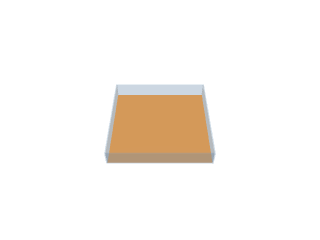

""

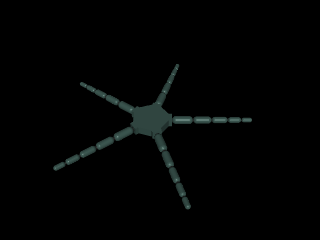

In [12]:
from bsc_utils.BrittleStarEnv import EnvContainer


config = load_config_from_yaml("2024_04_01_b01_r03.yaml")
config = complete_config_with_defaults(config)
config["environment"]["simulation_time"] = simulation_time

env_container = EnvContainer(config)
env_container.generate_env()
env_container.generate_env_damaged()
env_container.visualize_arena()
env_container.visualize_morphology()

In [13]:
rng, rng_reset = jax.random.split(rng, 2)
env_state = env_container.env.reset(rng_reset)
mjx_frames = []

i = 0
while not jnp.any(env_state.terminated | env_state.truncated):
    if i%10 == 0:
        print(i)
    i += 1
    
    sensory_input = jnp.concatenate(
        [env_state.observations[label] for label in config["environment"]["sensor_selection"]],
        # axis = 1
    )

    start_action = time.time()
    action,_ = cons_contr.apply(cons_contr_params, sensory_input)
    print(f"action rollout time = {time.time()-start_action}")

    start_env_step = time.time()
    env_state = env_container.env.step(state=env_state, action=action)
    print(f"env step time = {time.time()-start_env_step}")
    
    mjx_frames.append(
            post_render(
                env_container.env.render(state=env_state),
                env_container.env.environment_configuration
                )
            )
show_video(images=mjx_frames)

/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


0
action rollout time = 0.006784677505493164


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 13.470183372497559
action rollout time = 0.006602764129638672


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 14.041691064834595
action rollout time = 0.005740165710449219


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 15.93035626411438
action rollout time = 0.005834341049194336


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 15.652003049850464
action rollout time = 0.00606226921081543


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 13.815199136734009
action rollout time = 0.006784677505493164


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 14.993698120117188
action rollout time = 0.0057981014251708984


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 14.431471109390259
action rollout time = 0.005606412887573242


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 15.036092758178711
action rollout time = 0.00672459602355957


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 14.156311273574829
action rollout time = 0.005583286285400391


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 15.110350847244263
10
action rollout time = 0.006487131118774414


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 14.594327926635742
action rollout time = 0.00615382194519043


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 15.624542951583862
action rollout time = 0.0061492919921875


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 14.924583673477173
action rollout time = 0.005697965621948242


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 15.19635796546936
action rollout time = 0.007923603057861328


/home/idlab515/OneDrive/Documents/DOCUMENTEN/4_PhD/BSC/bsc/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:133: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


env step time = 16.62286067008972
